In [203]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Question 1 - Pre-Processing of Data

In [50]:
data = pd.read_csv('Weather Data.csv')
data.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [57]:
def month_to_season(month):
    if month in [8, 9, 10]:  # Autumn
        return 0
    elif month in [11, 0, 1]: # Winter
        return 1
    elif month in [2, 3, 4]:  # Spring
        return 2
    else:                     # Summer
        return 3

# Create Hour. Month, Season fields
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data['Hour'] = data['Date/Time'].dt.hour
data['Month'] = data['Date/Time'].dt.month - 1
data['Season'] = data['Month'].apply(month_to_season)

# Remove the 'Date/Time'
data.drop('Date/Time', axis=1, inplace=True)

data.head()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather,Hour,Month,Season
0,-1.8,-3.9,86,4,8.0,101.24,Fog,0,0,1
1,-1.8,-3.7,87,4,8.0,101.24,Fog,1,0,1
2,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog",2,0,1
3,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog",3,0,1
4,-1.5,-3.3,88,7,4.8,101.23,Fog,4,0,1


In [58]:
data['Weather'] = data['Weather'].apply(lambda x: x.split(',')[0] if ',' in x else x)

# Simplify the values
weather_mappings = {
    'Freezing Drizzle': 'Drizzle',
    'Mostly Cloudy': 'Cloudy',
    'Rain Showers': 'Rain',
    'Mainly Clear': 'Clear',
    'Snow Showers': 'Snow',
    'Freezing Rain': 'Rain',
    'Moderate Snow': 'Snow',
    'Freezing Fog': 'Fog',
    'Haze': 'Fog',
    'Snow Pellets': 'Snow',
    'Moderate Rain': 'Rain'
}

data['Weather'] = data['Weather'].replace(weather_mappings)

# Display the unique values after mapping the new values
weather_unique = data['Weather'].unique()
print(weather_unique)

['Fog' 'Drizzle' 'Cloudy' 'Rain' 'Clear' 'Snow' 'Thunderstorms']


In [59]:
print('Original number of rows: ',len(data))

# Remove any rows with missing values
data = data.dropna()

print('Number of rows after dropna(): ',len(data))

Original number of rows:  8784
Number of rows after dropna():  8784


No rows of data have a null value

In [60]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temp_C            8784 non-null   float64
 1   Dew Point Temp_C  8784 non-null   float64
 2   Rel Hum_%         8784 non-null   int64  
 3   Wind Speed_km/h   8784 non-null   int64  
 4   Visibility_km     8784 non-null   float64
 5   Press_kPa         8784 non-null   float64
 6   Weather           8784 non-null   object 
 7   Hour              8784 non-null   int64  
 8   Month             8784 non-null   int64  
 9   Season            8784 non-null   int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 686.4+ KB
None


# Question 2 - Data Analysis

In [61]:
data.describe()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Hour,Month,Season
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,8.798144,2.555294,67.431694,14.945469,27.664447,101.051623,11.500000,5.513661,1.505464
std,11.687883,10.883072,16.918881,8.688696,12.622688,0.844005,6.922581,3.451430,1.118084
min,-23.300000,-28.500000,18.000000,0.000000,0.200000,97.520000,0.000000,0.000000,0.000000
25%,0.100000,-5.900000,56.000000,9.000000,24.100000,100.560000,5.750000,3.000000,1.000000
50%,9.300000,3.300000,68.000000,13.000000,25.000000,101.070000,11.500000,6.000000,2.000000
75%,18.800000,11.800000,81.000000,20.000000,25.000000,101.590000,17.250000,9.000000,3.000000
max,33.000000,24.400000,100.000000,83.000000,48.300000,103.650000,23.000000,11.000000,3.000000


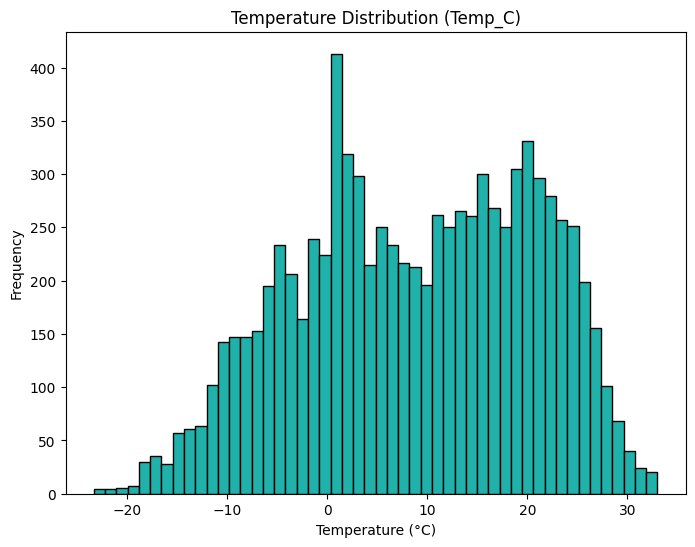

In [62]:
# Temp_C Distribution
plt.figure(figsize=(8, 6))
plt.hist(data['Temp_C'], bins=50, color='lightseagreen', edgecolor='black')
plt.title('Temperature Distribution (Temp_C)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
# plt.grid(True)
plt.show()

plt.show()

The temperature distribution in our dataset appears to be bimodal, with two prominent peaks around 0°C and 20°C. This suggests that our data encompasses two distinct temperature ranges, likely reflecting colder and warmer seasons

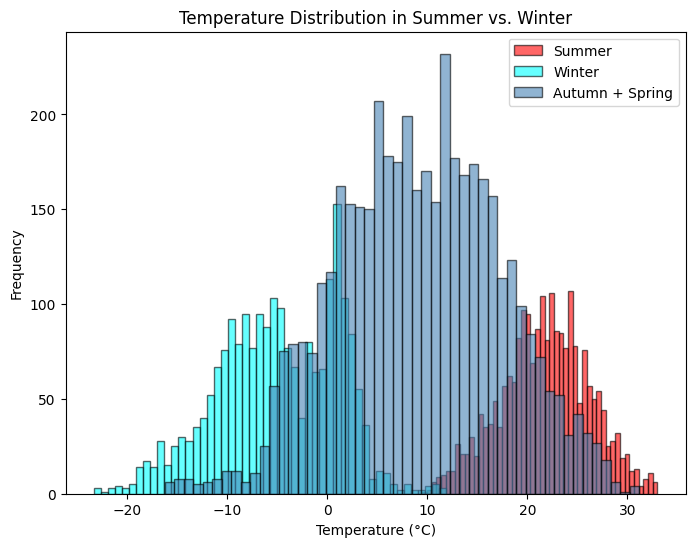

In [106]:
# Select Winter and Summer data
summer_data = data[data['Season']== 3]
winter_data = data[data['Season']== 1]
autumn_spring_data = data[(data['Season']== 0) | (data['Season']== 2)]

plt.figure(figsize=(8, 6))

plt.hist(summer_data['Temp_C'], bins=50, alpha=0.6, label='Summer', color='red', edgecolor='black')
plt.hist(winter_data['Temp_C'], bins=50, alpha=0.6, label='Winter', color='cyan', edgecolor='black')
plt.hist(autumn_spring_data['Temp_C'], bins=50, alpha=0.6, label='Autumn + Spring',color='steelblue', edgecolor='black')

plt.title('Temperature Distribution in Summer vs. Winter')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can identify that out dataset consists of 3 normal distribution for the Temperatures of Summer, Winter and Spring with Autumn that display the same range of values

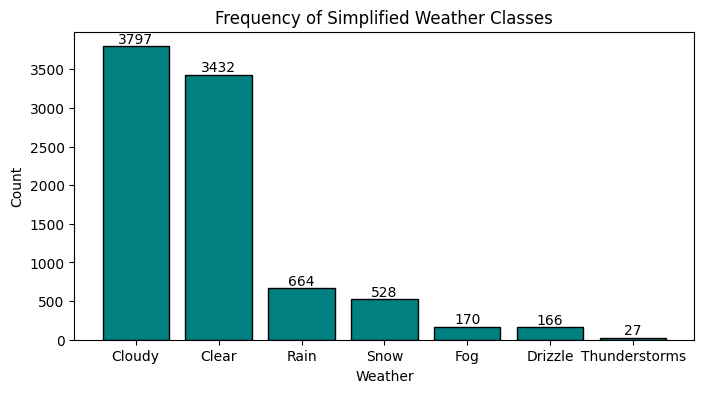

In [127]:
# Counting the number of unique values in the 'Weather' column
weather_counts = data['Weather'].value_counts()

# Plotting the bar plot with data labels for the simplified weather types
plt.figure(figsize=(8, 4))
bars = plt.bar(weather_counts.index, weather_counts, color='teal', edgecolor='black')

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Frequency of Simplified Weather Classes')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The weather classes are not balanced. 'Cloudy' and 'Clear' dominate the dataset, while classes like 'Thunderstorms', 'Drizzle', and 'Fog' are less frequent.

# Question 3 - Temperature Prediction

In [131]:
# Converte the 'Weather' column to one-hot encoded vectors
weather_one_hot = pd.get_dummies(data['Weather'])
weather_data_one_hot = data.drop('Weather', axis=1)
data = pd.concat([weather_data_one_hot, weather_one_hot], axis=1)

target_column = 'Temp_C'

data.head()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Hour,Month,Season,Clear,Cloudy,Drizzle,Fog,Rain,Snow,Thunderstorms
0,-1.8,-3.9,86,4,8.0,101.24,0,0,1,0,0,0,1,0,0,0
1,-1.8,-3.7,87,4,8.0,101.24,1,0,1,0,0,0,1,0,0,0
2,-1.8,-3.4,89,7,4.0,101.26,2,0,1,0,0,1,0,0,0,0
3,-1.5,-3.2,88,6,4.0,101.27,3,0,1,0,0,1,0,0,0,0
4,-1.5,-3.3,88,7,4.8,101.23,4,0,1,0,0,0,1,0,0,0


In [204]:
X = data.drop('Temp_C', axis=1)
Y = data['Temp_C']

# Split the dataset into train and temp (temp will be used to split into validation and test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=0)

# Split the dataset into validation and test
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=0)

# Normalize with MaxAbsScaler
scaler_new = MaxAbsScaler()
X_train_scaled = scaler_new.fit_transform(X_train)
X_val_scaled = scaler_new.transform(X_val)
X_test_scaled = scaler_new.transform(X_test)

print("Train set size: ", len(X_train_scaled))
print("Validation set size: ", len(X_val_scaled))
print("Test set size: ", len(X_test_scaled))

Train set size:  6148
Validation set size:  1757
Test set size:  879


In [146]:
# The number of neighbors for KNN
k_values = [5, 15, 25, 35, 45, 55, 65, 95]
mae_scores = []

# Train a KNN Regressor with the different k values
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train_scaled, Y_train)
    Y_pred_val = knn.predict(X_val_scaled)
    mae = mean_absolute_error(Y_val, Y_pred_val)
    mae_scores.append(mae)

# Save the MAE scores for every k value
mae_df = pd.DataFrame({'K': k_values, 'MAE': mae_scores})
print(mae_df)

    K       MAE
0   5  0.969167
1  15  1.244214
2  25  1.425690
3  35  1.565462
4  45  1.684869
5  55  1.781635
6  65  1.866929
7  95  2.100821


5 neighbors displayed the least mean absolute error, we will use it to train a test our model

In [161]:
# Select the min MAE (k=5 in our case)
best_k = k_values[mae_scores.index(min(mae_scores))]

# Train the final model
X_train_final_scaled = np.concatenate((X_train_scaled, X_val_scaled))
Y_train_final = pd.concat([Y_train, Y_val])

knn_final = KNeighborsRegressor(n_neighbors=best_k, weights='distance')
knn_final.fit(X_train_final_scaled, Y_train_final)

# Evaluate the final model on the test set
Y_test_pred = knn_final.predict(X_test_scaled)
final_mae = mean_absolute_error(Y_test, Y_test_pred)
final_r2 = r2_score(Y_test, Y_test_pred)
final_std = Y_test_pred.std()

print("Number of neighbors: ", best_k)
print("-------------------------\n         Results\n-------------------------")
print("MAE: ", final_mae)
print("R2: ", final_r2)
print("STD: ", final_std)

Number of neighbors:  5
-------------------------
         Results
-------------------------
MAE:  0.8830005622365381
R2:  0.9875055099175356
STD:  11.236375577607802


In [167]:
# Applying 5-K cross validation to find the best k value
cross_val_mae_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_train_scaled, Y_train, scoring='neg_mean_absolute_error', cv=5)
    cross_val_mae_scores.append(-scores.mean())

# Save the MAE scores for every k value
cross_val_mae_scores_df = pd.DataFrame({'K': k_values, 'MAE': cross_val_mae_scores})
print(cross_val_mae_scores_df)

    K       MAE
0   5  1.090017
1  15  1.373558
2  25  1.567819
3  35  1.730715
4  45  1.856771
5  55  1.970670
6  65  2.067491
7  95  2.302192


Cross Validation showcased the same k (5) as the best number of neighbors for KNN

### Validation

- MAE measures the average error in the model’s predictions, regardless of direction.
- STD of the error shows how spread out the errors are in your model’s predictions.
  - A lower standard deviation means that the errors are more concentrated around the MAE value, indicating consistency in the model’s errors.

Ideally, we want a model with low MAE and low STD of errors, as it indicates both accuracy (due to low MAE) and reliability (due to low STD) in the predictions.


# Question 4 - Weather Forecast

In [188]:
q4_data = data.copy()
q4_data = q4_data[(q4_data['Clear']==1) | (q4_data['Snow']==1)]
q4_data

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Hour,Month,Season,Clear,Cloudy,Drizzle,Fog,Rain,Snow,Thunderstorms
36,1.7,-6.2,56,48,24.1,99.21,12,0,1,1,0,0,0,0,0,0
41,-2.1,-9.5,57,22,25.0,99.66,17,0,1,0,0,0,0,0,1,0
44,-5.6,-13.4,54,24,25.0,100.07,20,0,1,0,0,0,0,0,1,0
45,-5.8,-12.8,58,26,25.0,100.15,21,0,1,0,0,0,0,0,1,0
47,-7.4,-14.1,59,17,19.3,100.27,23,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,0.1,-2.7,81,30,9.7,100.13,19,11,1,0,0,0,0,0,1,0
8780,0.2,-2.4,83,24,9.7,100.03,20,11,1,0,0,0,0,0,1,0
8781,-0.5,-1.5,93,28,4.8,99.95,21,11,1,0,0,0,0,0,1,0
8782,-0.2,-1.8,89,28,9.7,99.91,22,11,1,0,0,0,0,0,1,0


In [189]:
# Snow will be our target since it represents 1 for snow and 0 for clear
q4_data.rename(columns={'Snow' : 'Weather'}, inplace=True)

q4_data = q4_data.drop(columns=['Cloudy', 'Drizzle', 'Fog', 'Rain', 'Thunderstorms','Clear'])

q4_data

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Hour,Month,Season,Weather
36,1.7,-6.2,56,48,24.1,99.21,12,0,1,0
41,-2.1,-9.5,57,22,25.0,99.66,17,0,1,1
44,-5.6,-13.4,54,24,25.0,100.07,20,0,1,1
45,-5.8,-12.8,58,26,25.0,100.15,21,0,1,1
47,-7.4,-14.1,59,17,19.3,100.27,23,0,1,1
...,...,...,...,...,...,...,...,...,...,...
8779,0.1,-2.7,81,30,9.7,100.13,19,11,1,1
8780,0.2,-2.4,83,24,9.7,100.03,20,11,1,1
8781,-0.5,-1.5,93,28,4.8,99.95,21,11,1,1
8782,-0.2,-1.8,89,28,9.7,99.91,22,11,1,1


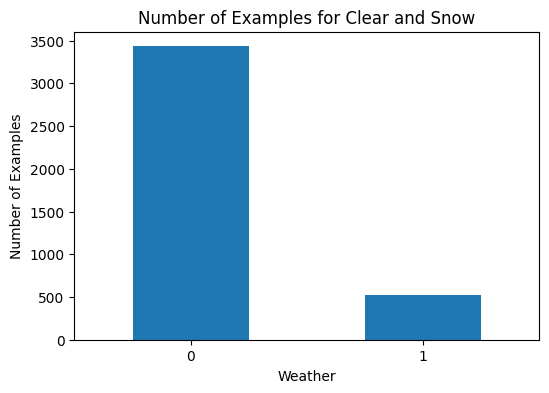

In [195]:
# Display the number of examples in each class using a bar plot
class_counts = q4_data['Weather'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title('Number of Examples for Clear and Snow')
plt.xlabel('Weather')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)  # Rotate labels to be horizontal
plt.show()

In [197]:
# Split and scale the data
X = q4_data.drop('Weather', axis=1)
Y = q4_data['Weather']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# normalization
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [200]:
k_values = [5, 15, 25, 35, 45, 55, 65, 95]

metrics = []

for k in k_values:

    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')

    knn.fit(X_train_scaled, Y_train)

    Y_pred = knn.predict(X_test_scaled)

    # Calculate and store the metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, zero_division=0)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)

    metrics.append([k, accuracy, precision, recall, f1])

metrics_df = pd.DataFrame(metrics, columns=['k', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
metrics_df

,k,Accuracy,Precision,Recall,F1 Score
0,5,0.971380,0.972789,0.826590,0.893750
1,15,0.965488,0.992537,0.768786,0.866450
2,25,0.958754,0.976923,0.734104,0.838284
3,35,0.957071,0.976562,0.722543,0.830565
4,45,0.956229,0.991870,0.705202,0.824324
5,55,0.953704,0.991667,0.687861,0.812287
6,65,0.952020,0.991525,0.676301,0.804124
7,95,0.947811,0.982609,0.653179,0.784722


Q: Which metric of accuracy and f1 is more reliable in this case and why?

> Since our dataset is inbalanced, high accuracy can be missleading if the model is only good at predicting the majority class while failing at the minority class. f1 becomes more important and reliable since we want both great accuracy in identifying the the majority of the correct positive values (recall) and the predicted values are indeed correct (precision)

Q: Suppose the application is intended for airline flight safety, where it is necessary to ensure favorable weather conditions (clear). Which of the 3 metrics accuracy, precision, recall, would be the most important? Explain

> Precision is the most important metric for this application. Ensuring that when our model predicts clear weather, it is indeed clear. This is crucial to ensure flight safety. While recall and accuracy are also important, the potential consequences of false positives in this context makes the model vulnerable to fatal decisions.

In [202]:
# Re-run KNN with stratify
X_train_strat, X_test_strat, Y_train_strat, Y_test_strat = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)

X_train_strat_scaled = scaler.fit_transform(X_train_strat)
X_test_strat_scaled = scaler.transform(X_test_strat)

metrics_strat = []

for k in k_values:
    knn_strat = KNeighborsClassifier(n_neighbors=k, weights='distance')

    knn_strat.fit(X_train_strat_scaled, Y_train_strat)

    Y_pred_strat = knn_strat.predict(X_test_strat_scaled)

    accuracy_strat = accuracy_score(Y_test_strat, Y_pred_strat)
    precision_strat = precision_score(Y_test_strat, Y_pred_strat, zero_division=0)
    recall_strat = recall_score(Y_test_strat, Y_pred_strat)
    f1_strat = f1_score(Y_test_strat, Y_pred_strat)

    metrics_strat.append([k, accuracy_strat, precision_strat, recall_strat, f1_strat])


metrics_strat_df = pd.DataFrame(metrics_strat, columns=['k', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
metrics_strat_df

,k,Accuracy,Precision,Recall,F1 Score
0,5,0.968855,0.948148,0.810127,0.873720
1,15,0.969697,1.000000,0.772152,0.871429
2,25,0.967172,0.991736,0.759494,0.860215
3,35,0.965488,1.000000,0.740506,0.850909
4,45,0.962121,0.991304,0.721519,0.835165
5,55,0.961279,1.000000,0.708861,0.829630
6,65,0.960438,1.000000,0.702532,0.825279
7,95,0.960438,1.000000,0.702532,0.825279


With Stratify we are ensuring that each split maintains a similar distribution of classes with the original dataset.

In this case we see some cases with 100% precision in identifying 'Snow'. Recall on the other hand is falling short.

Based on the f1 score, k=5 is again the best performing value for the number of neighbors